<a href="https://colab.research.google.com/github/deepakgowtham/EVA4/blob/master/Week10/Session_10_CIFAR_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir temp

In [0]:
%%bash
git clone https://github.com/bikash-bhoi/eva4.git temp
if [ ! -d ./models ]; then
    mkdir models
fi
if [ ! -d ./utils ]; then
    mkdir utils
fi
cp -r temp/models/* ./models
cp -r temp/utils/* ./utils
rm -rf temp

Cloning into 'temp'...


In [0]:
!pip install pytorch-gradcam
!pip install albumentations
!pip install apex

In [0]:
from utils.download_load import download_load
from utils.display_imgs import display_imgs
from utils.train_test import train , test, predict, get_misclassified
from utils.disp_summary import disp_summary
from utils.gradcam import grad_cam, gradcam_plot
from utils.lr_finder import LRFinder
from models.resnet import ResNet18

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import torchvision
import torchsummary
from torchsummary import summary
import torch

In [0]:
trainset, testset, train_loader, test_loader, classes =download_load()

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


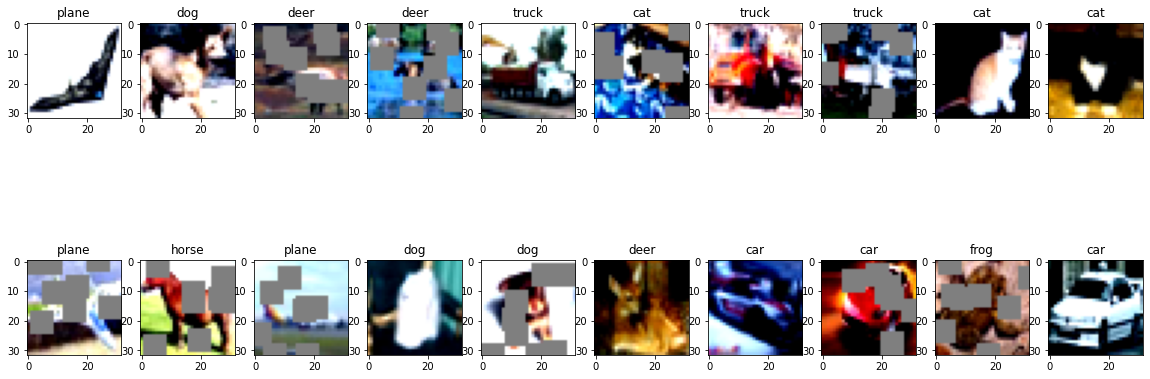

In [0]:
display_imgs(train_loader, classes)

In [0]:
use_cuda= torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
model=ResNet18().to(device)

In [0]:
disp_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         Dropout2d-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
        Dropout2d-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

/content/models/resnet.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


/content/models/resnet.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


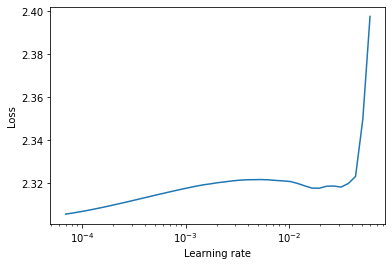

In [0]:
## LR Finder code
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,  momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-06, eps=1e-06)

for epoch in range(1, 51):
    curr_lr=optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch} Learning_Rate {curr_lr}')
    train(model, device, train_loader, optimizer, epoch)
    test_acc1 = test(model, device, test_loader)
    print('Test acc:', test_acc1)
    scheduler.step(test_acc1)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate 0.01


/content/models/resnet.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=1.8676856756210327 Batch_id=781 Accuracy=30.93: 100%|██████████| 782/782 [00:38<00:00, 20.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5165, Accuracy: 4391/10000 (43.91%)

Test acc: 43.91
Epoch: 2 Learning_Rate 0.01


Loss=1.5370702743530273 Batch_id=781 Accuracy=41.06: 100%|██████████| 782/782 [00:38<00:00, 20.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3628, Accuracy: 4978/10000 (49.78%)

Test acc: 49.78
Epoch: 3 Learning_Rate 0.01


Loss=1.1200826168060303 Batch_id=781 Accuracy=46.66: 100%|██████████| 782/782 [00:38<00:00, 20.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2601, Accuracy: 5461/10000 (54.61%)

Test acc: 54.61
Epoch: 4 Learning_Rate 0.01


Loss=1.534828543663025 Batch_id=781 Accuracy=51.09: 100%|██████████| 782/782 [00:38<00:00, 20.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0927, Accuracy: 5982/10000 (59.82%)

Test acc: 59.82
Epoch: 5 Learning_Rate 0.01


Loss=1.3065402507781982 Batch_id=781 Accuracy=55.18: 100%|██████████| 782/782 [00:38<00:00, 20.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9612, Accuracy: 6532/10000 (65.32%)

Test acc: 65.32
Epoch: 6 Learning_Rate 0.01


Loss=1.1507186889648438 Batch_id=781 Accuracy=58.23: 100%|██████████| 782/782 [00:38<00:00, 20.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9116, Accuracy: 6758/10000 (67.58%)

Test acc: 67.58
Epoch: 7 Learning_Rate 0.01


Loss=1.5110599994659424 Batch_id=781 Accuracy=61.91: 100%|██████████| 782/782 [00:38<00:00, 20.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7989, Accuracy: 7187/10000 (71.87%)

Test acc: 71.87
Epoch: 8 Learning_Rate 0.01


Loss=1.0689408779144287 Batch_id=781 Accuracy=64.23: 100%|██████████| 782/782 [00:38<00:00, 20.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7317, Accuracy: 7431/10000 (74.31%)

Test acc: 74.31
Epoch: 9 Learning_Rate 0.01


Loss=1.5189518928527832 Batch_id=781 Accuracy=66.25: 100%|██████████| 782/782 [00:37<00:00, 20.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7227, Accuracy: 7563/10000 (75.63%)

Test acc: 75.63
Epoch: 10 Learning_Rate 0.01


Loss=0.9363309144973755 Batch_id=781 Accuracy=68.05: 100%|██████████| 782/782 [00:37<00:00, 20.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6517, Accuracy: 7777/10000 (77.77%)

Test acc: 77.77
Epoch: 11 Learning_Rate 0.01


Loss=0.5969828367233276 Batch_id=781 Accuracy=69.70: 100%|██████████| 782/782 [00:37<00:00, 20.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6261, Accuracy: 7839/10000 (78.39%)

Test acc: 78.39
Epoch: 12 Learning_Rate 0.01


Loss=0.8104472756385803 Batch_id=781 Accuracy=70.90: 100%|██████████| 782/782 [00:38<00:00, 20.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5778, Accuracy: 8020/10000 (80.20%)

Test acc: 80.2
Epoch: 13 Learning_Rate 0.01


Loss=1.0445780754089355 Batch_id=781 Accuracy=72.43: 100%|██████████| 782/782 [00:38<00:00, 20.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5674, Accuracy: 8076/10000 (80.76%)

Test acc: 80.76
Epoch: 14 Learning_Rate 0.01


Loss=0.4261142909526825 Batch_id=781 Accuracy=73.26: 100%|██████████| 782/782 [00:38<00:00, 20.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5441, Accuracy: 8109/10000 (81.09%)

Test acc: 81.09
Epoch: 15 Learning_Rate 0.01


Loss=0.4012013375759125 Batch_id=781 Accuracy=74.34: 100%|██████████| 782/782 [00:38<00:00, 20.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5390, Accuracy: 8152/10000 (81.52%)

Test acc: 81.52
Epoch: 16 Learning_Rate 0.01


Loss=0.9387596845626831 Batch_id=781 Accuracy=75.07: 100%|██████████| 782/782 [00:38<00:00, 20.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5239, Accuracy: 8180/10000 (81.80%)

Test acc: 81.8
Epoch: 17 Learning_Rate 0.01


Loss=0.9045632481575012 Batch_id=781 Accuracy=75.86: 100%|██████████| 782/782 [00:38<00:00, 20.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 8381/10000 (83.81%)

Test acc: 83.81
Epoch: 18 Learning_Rate 0.01


Loss=0.5244854092597961 Batch_id=781 Accuracy=76.54: 100%|██████████| 782/782 [00:37<00:00, 20.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5028, Accuracy: 8286/10000 (82.86%)

Test acc: 82.86
Epoch: 19 Learning_Rate 0.01


Loss=0.7709134221076965 Batch_id=781 Accuracy=77.26: 100%|██████████| 782/782 [00:37<00:00, 20.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4686, Accuracy: 8430/10000 (84.30%)

Test acc: 84.3
Epoch: 20 Learning_Rate 0.01


Loss=0.6939100027084351 Batch_id=781 Accuracy=78.01: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4725, Accuracy: 8437/10000 (84.37%)

Test acc: 84.37
Epoch: 21 Learning_Rate 0.01


Loss=0.6216294765472412 Batch_id=781 Accuracy=78.50: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4547, Accuracy: 8476/10000 (84.76%)

Test acc: 84.76
Epoch: 22 Learning_Rate 0.01


Loss=0.8687669038772583 Batch_id=781 Accuracy=79.33: 100%|██████████| 782/782 [00:37<00:00, 20.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4448, Accuracy: 8537/10000 (85.37%)

Test acc: 85.37
Epoch: 23 Learning_Rate 0.01


Loss=0.3912671208381653 Batch_id=781 Accuracy=79.83: 100%|██████████| 782/782 [00:37<00:00, 20.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4382, Accuracy: 8511/10000 (85.11%)

Test acc: 85.11
Epoch: 24 Learning_Rate 0.01


Loss=0.5740229487419128 Batch_id=781 Accuracy=79.92: 100%|██████████| 782/782 [00:37<00:00, 21.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4215, Accuracy: 8573/10000 (85.73%)

Test acc: 85.73
Epoch: 25 Learning_Rate 0.01


Loss=0.39705878496170044 Batch_id=781 Accuracy=80.34: 100%|██████████| 782/782 [00:37<00:00, 20.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4366, Accuracy: 8566/10000 (85.66%)

Test acc: 85.66
Epoch: 26 Learning_Rate 0.01


Loss=0.8122086524963379 Batch_id=781 Accuracy=80.87: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4149, Accuracy: 8617/10000 (86.17%)

Test acc: 86.17
Epoch: 27 Learning_Rate 0.01


Loss=0.67510586977005 Batch_id=781 Accuracy=81.45: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4102, Accuracy: 8623/10000 (86.23%)

Test acc: 86.23
Epoch: 28 Learning_Rate 0.01


Loss=0.7778945565223694 Batch_id=781 Accuracy=81.69: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4030, Accuracy: 8679/10000 (86.79%)

Test acc: 86.79
Epoch: 29 Learning_Rate 0.01


Loss=0.9453275799751282 Batch_id=781 Accuracy=82.21: 100%|██████████| 782/782 [00:37<00:00, 21.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4008, Accuracy: 8676/10000 (86.76%)

Test acc: 86.76
Epoch: 30 Learning_Rate 0.01


Loss=0.7882645726203918 Batch_id=781 Accuracy=82.44: 100%|██████████| 782/782 [00:37<00:00, 21.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3888, Accuracy: 8736/10000 (87.36%)

Test acc: 87.36
Epoch: 31 Learning_Rate 0.01


Loss=0.7837604284286499 Batch_id=781 Accuracy=82.94: 100%|██████████| 782/782 [00:37<00:00, 20.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4015, Accuracy: 8701/10000 (87.01%)

Test acc: 87.01
Epoch: 32 Learning_Rate 0.01


Loss=0.33471983671188354 Batch_id=781 Accuracy=82.98: 100%|██████████| 782/782 [00:37<00:00, 21.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3782, Accuracy: 8752/10000 (87.52%)

Test acc: 87.52
Epoch: 33 Learning_Rate 0.01


Loss=0.24907884001731873 Batch_id=781 Accuracy=83.49: 100%|██████████| 782/782 [00:37<00:00, 21.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3668, Accuracy: 8775/10000 (87.75%)

Test acc: 87.75
Epoch: 34 Learning_Rate 0.01


Loss=1.3556747436523438 Batch_id=781 Accuracy=83.79: 100%|██████████| 782/782 [00:37<00:00, 21.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3726, Accuracy: 8781/10000 (87.81%)

Test acc: 87.81
Epoch: 35 Learning_Rate 0.01


Loss=0.40091797709465027 Batch_id=781 Accuracy=84.24: 100%|██████████| 782/782 [00:37<00:00, 21.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3638, Accuracy: 8829/10000 (88.29%)

Test acc: 88.29
Epoch: 36 Learning_Rate 0.01


Loss=0.47713372111320496 Batch_id=781 Accuracy=84.43: 100%|██████████| 782/782 [00:37<00:00, 21.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3625, Accuracy: 8822/10000 (88.22%)

Test acc: 88.22
Epoch: 37 Learning_Rate 0.01


Loss=0.49586641788482666 Batch_id=781 Accuracy=84.38: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3561, Accuracy: 8826/10000 (88.26%)

Test acc: 88.26
Epoch: 38 Learning_Rate 0.01


Loss=0.467742919921875 Batch_id=781 Accuracy=85.17: 100%|██████████| 782/782 [00:37<00:00, 21.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3562, Accuracy: 8865/10000 (88.65%)

Test acc: 88.65
Epoch: 39 Learning_Rate 0.01


Loss=0.6177400350570679 Batch_id=781 Accuracy=85.49: 100%|██████████| 782/782 [00:37<00:00, 21.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3558, Accuracy: 8850/10000 (88.50%)

Test acc: 88.5
Epoch: 40 Learning_Rate 0.01


Loss=1.1547774076461792 Batch_id=781 Accuracy=85.64: 100%|██████████| 782/782 [00:37<00:00, 21.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3608, Accuracy: 8846/10000 (88.46%)

Test acc: 88.46
Epoch: 41 Learning_Rate 0.01


Loss=1.0622692108154297 Batch_id=781 Accuracy=85.93: 100%|██████████| 782/782 [00:37<00:00, 21.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3645, Accuracy: 8829/10000 (88.29%)

Test acc: 88.29
Epoch    41: reducing learning rate of group 0 to 5.0000e-03.
Epoch: 42 Learning_Rate 0.005


Loss=0.3870009481906891 Batch_id=781 Accuracy=86.89: 100%|██████████| 782/782 [00:37<00:00, 21.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3317, Accuracy: 8948/10000 (89.48%)

Test acc: 89.48
Epoch: 43 Learning_Rate 0.005


Loss=0.4021032154560089 Batch_id=781 Accuracy=87.63: 100%|██████████| 782/782 [00:37<00:00, 21.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3260, Accuracy: 8946/10000 (89.46%)

Test acc: 89.46
Epoch: 44 Learning_Rate 0.005


Loss=0.1882762461900711 Batch_id=781 Accuracy=87.66: 100%|██████████| 782/782 [00:37<00:00, 21.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3264, Accuracy: 8966/10000 (89.66%)

Test acc: 89.66
Epoch: 45 Learning_Rate 0.005


Loss=0.338858962059021 Batch_id=781 Accuracy=88.07: 100%|██████████| 782/782 [00:37<00:00, 21.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3304, Accuracy: 8983/10000 (89.83%)

Test acc: 89.83
Epoch: 46 Learning_Rate 0.005


Loss=0.5445640087127686 Batch_id=781 Accuracy=88.19: 100%|██████████| 782/782 [00:37<00:00, 21.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3233, Accuracy: 8983/10000 (89.83%)

Test acc: 89.83
Epoch: 47 Learning_Rate 0.005


Loss=0.7008192539215088 Batch_id=781 Accuracy=88.35: 100%|██████████| 782/782 [00:37<00:00, 20.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3220, Accuracy: 9011/10000 (90.11%)

Test acc: 90.11
Epoch: 48 Learning_Rate 0.005


Loss=0.7709006071090698 Batch_id=781 Accuracy=88.61: 100%|██████████| 782/782 [00:37<00:00, 21.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3256, Accuracy: 8980/10000 (89.80%)

Test acc: 89.8
Epoch: 49 Learning_Rate 0.005


Loss=0.5639692544937134 Batch_id=781 Accuracy=88.78: 100%|██████████| 782/782 [00:37<00:00, 21.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3430, Accuracy: 8965/10000 (89.65%)

Test acc: 89.65
Epoch: 50 Learning_Rate 0.005


Loss=0.2448434829711914 Batch_id=781 Accuracy=88.78: 100%|██████████| 782/782 [00:37<00:00, 21.08it/s]



Test set: Average loss: 0.3101, Accuracy: 9026/10000 (90.26%)

Test acc: 90.26


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
PATH = '/content/gdrive/My Drive/Colab Notebooks/eva4_s9/assignment10_ResNet18V2_model.h5'
!touch PATH
torch.save(model.state_dict(), PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18().to(device)
PATH = '/content/gdrive/My Drive/Colab Notebooks/eva4_s9/assignment10_ResNet18V2_model.h5'
model.load_state_dict(torch.load(PATH))

Mounted at /content/gdrive


<All keys matched successfully>

/content/models/resnet.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/content/utils/gradcam.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2)


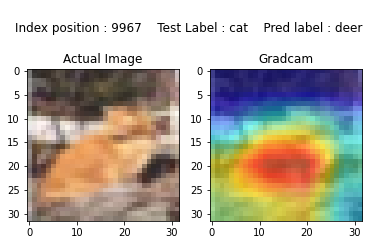

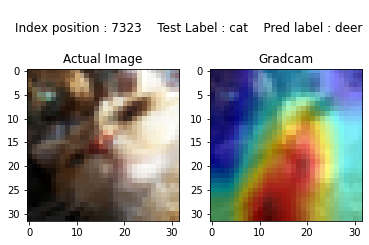

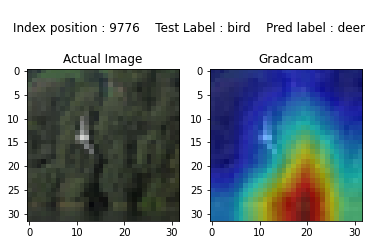

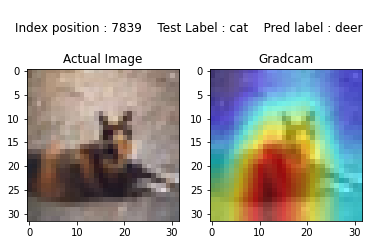

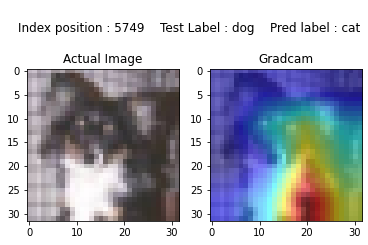

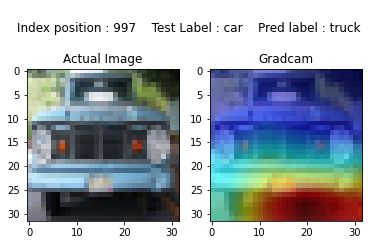

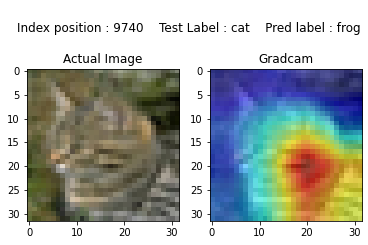

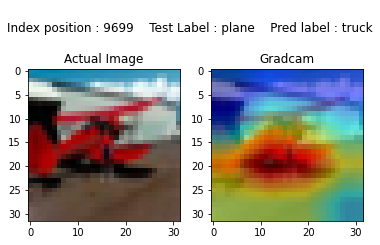

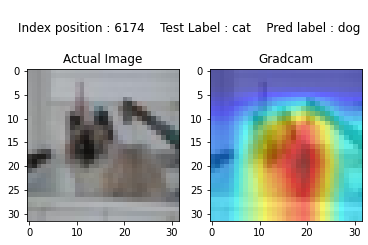

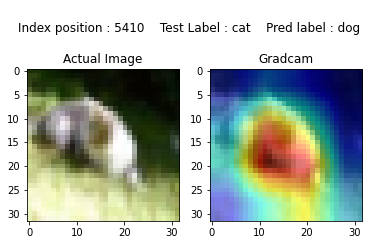

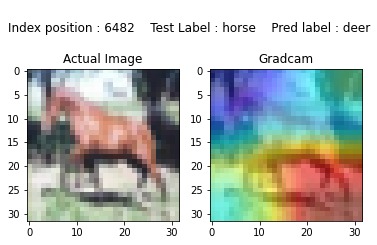

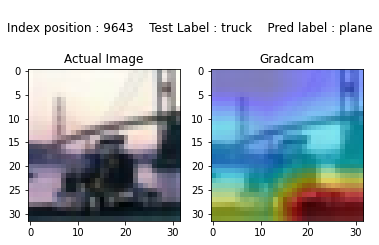

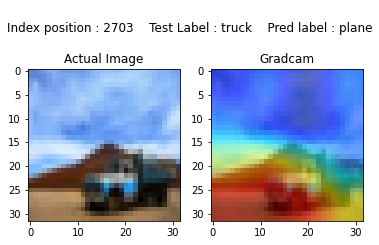

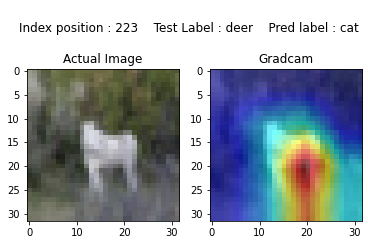

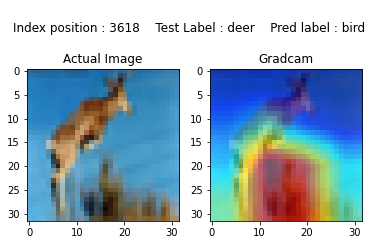

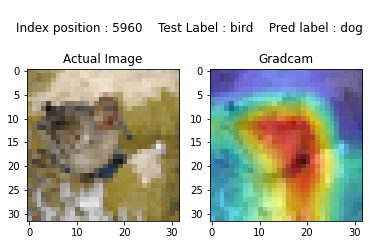

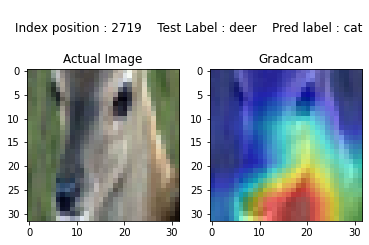

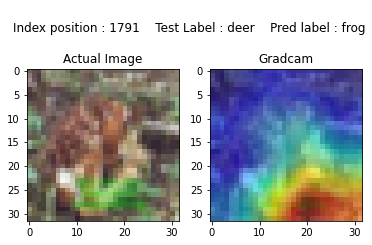

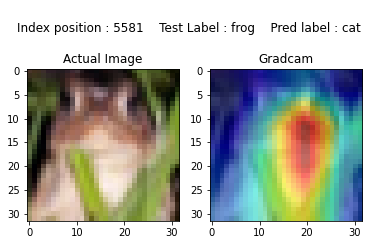

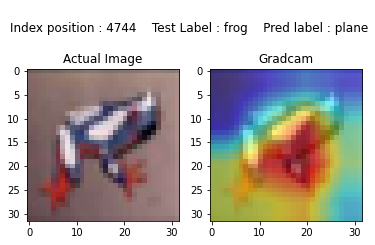

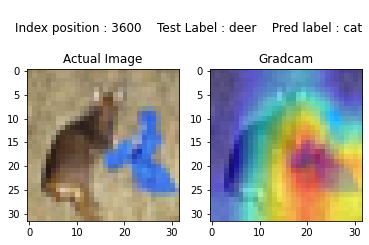

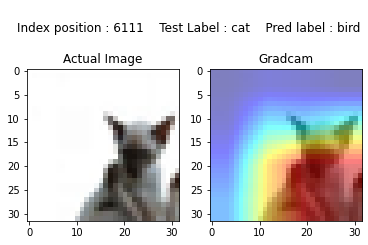

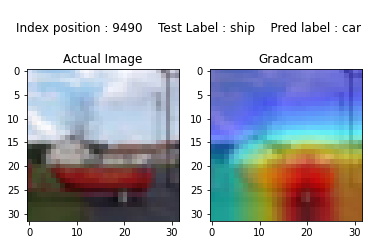

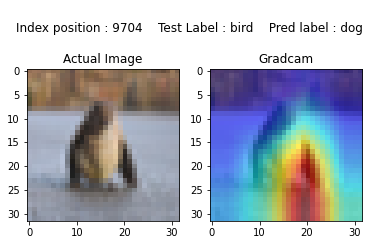

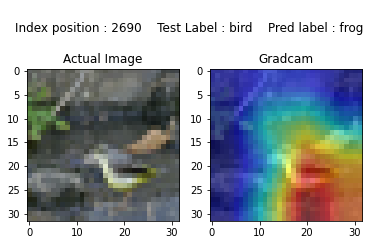

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
pred = predict(model,device,test_loader)
correct,missclassified = get_misclassified(pred,testset.targets)

layer='layer4'
gradcam_plot(layer,model,missclassified,25,testset,classes)
